<a href="https://colab.research.google.com/github/asarria48/Nuclear-physics/blob/main/Informe3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparación

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

<>:46: SyntaxWarning: invalid escape sequence '\g'
<>:46: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2403283608.py:46: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ [Cuentas/canal]", fontsize=14)


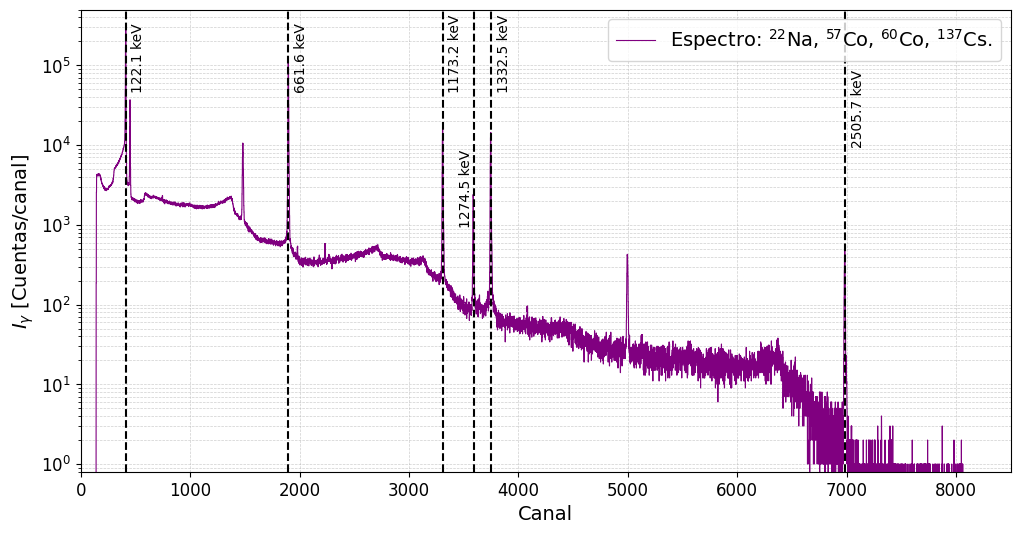

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# leo los espectros
varios = pd.read_csv("calibracionNaCoCoCs-Ge8K.xy", sep=r"\s+", header=None)
euro = pd.read_csv("calibracionEu-Ge8K.xy", sep=r"\s+", header=None)

# nombres de columnas
varios.columns = ["canal", "cuentas"]
euro.columns = ["canal", "cuentas"]

df = varios                                                                     # por ahora solo me interesan estos espectros

plt.figure(figsize=(12,6))
plt.plot(df["canal"], df["cuentas"], ds="steps-mid", color='purple', lw=0.8, label="Espectro: $^{22}$Na, $^{57}$Co, $^{60}$Co, $^{137}$Cs.")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

# aquí meto los picos "a ojo" que ya conozco

plt.axvline(410, color='black', lw=1.5,linestyle='--')
plt.text(410 + 50, 1e4*5, f'122.1 keV', color='black',rotation=90, fontsize=10)     # del cobalto 57

plt.axvline(1895, color='black', lw=1.5,linestyle='--')
plt.text(1895 + 50, 1e4*5, f'661.6 keV', color='black',rotation=90, fontsize=10)    # del cesio 137

plt.axvline(3310, color='black', lw=1.5,linestyle='--')
plt.text(3310 + 50, 1e4*5, f'1173.2 keV', color='black',rotation=90, fontsize=10)   # "primero" del cobalto 60

plt.axvline(3750, color='black', lw=1.5,linestyle='--')
plt.text(3750 + 50, 1e4*5, f'1332.5 keV', color='black',rotation=90, fontsize=10)   # "segundo" del cobalto 60

plt.axvline(6985, color='black', lw=1.5,linestyle='--')
plt.text(6985 + 50, 1e4, f'2505.7 keV', color='black', rotation=90, fontsize=10)    # resultado de la suma de los dos picos del cobalto 60

plt.axvline(3590, color='black', lw=1.5,linestyle='--')
plt.text(3590 - 130, 1e3, f'1274.5 keV', color='black',rotation=90, fontsize=10)    # del sodio 22


plt.xlim(0, 8500)
plt.yscale("log")
plt.ylim(0.8, 5e5)

plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I_\gamma$ [Cuentas/canal]", fontsize=14)
plt.legend(fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()
